In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score


## gender

In [5]:
males1= pd.read_csv('../CSVs/general_0.csv')
males2= pd.read_csv('../CSVs/general_1.csv')
females1= pd.read_csv('../CSVs/females_0.csv')
females2= pd.read_csv('../CSVs/females_1.csv')

males= pd.concat([males1, males2], axis=0)
females=pd.concat([females1, females2], axis=0)
males['gender']=1
females['gender']=0
df=pd.concat([males,females], axis=0)


In [53]:
df=pd.read_csv('all_features.csv')

In [54]:
df.dropna(inplace=True)

<Axes: xlabel='gender'>

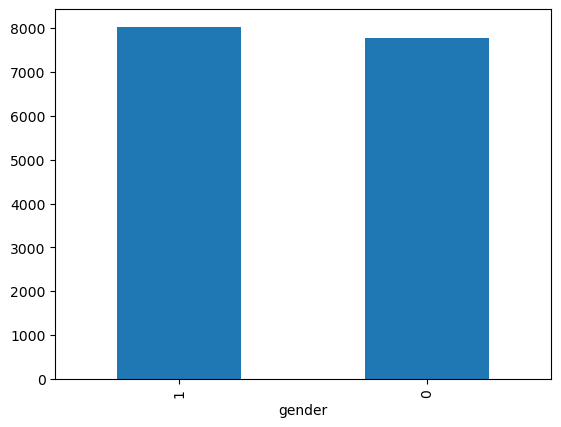

In [55]:
df['gender'].value_counts().plot(kind='bar')

In [56]:
# Separate majority and minority classes
df_majority = df[df['gender'] == df['gender'].value_counts().idxmax()]
df_minority = df[df['gender'] == df['gender'].value_counts().idxmin()]

# OPTION 1: Undersample majority class
df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# ## drop the columns that are not needed
selected_columns=['meanF0Hz','stdevF0Hz','localabsoluteJitter','f1_median','HNR','apq5Shimmer','f4_mean','f4_median','gender']
# general=df_balanced.loc[:, selected_columns]
general=df_balanced.copy()

In [58]:
general.drop(['voiceID'],inplace=True, axis=1)

In [59]:
X_train=general.drop(['gender'],axis=1)
y_train=general['gender']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1,stratify=general['gender'], random_state=42)

In [62]:
def evaluate_model(y,y_hat):
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    f1 = f1_score(y, y_hat)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    cm = confusion_matrix(y, y_hat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


In [63]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [64]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

# ML models

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Train Evaluation
Precision: 0.9416
Recall: 0.9257
F1 Score: 0.9336


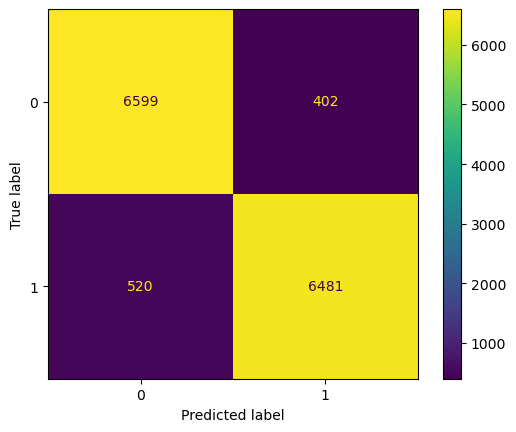

Test Evaluation
Precision: 0.9302
Recall: 0.9254
F1 Score: 0.9278


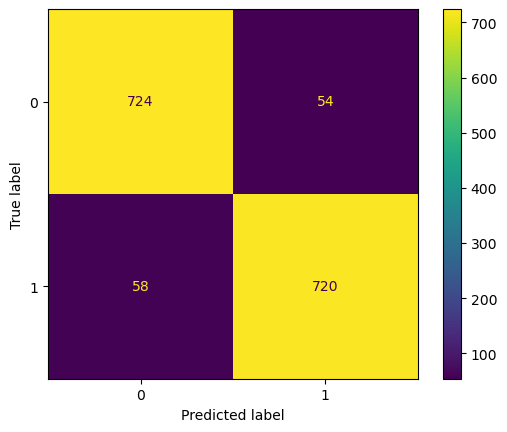

Cross-Validation Accuracy: 0.9176
Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [66]:
# Define the base model
clf = DecisionTreeClassifier(random_state=42)

# Define the hyperparameters grid to search
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,                  # 5-fold cross-validation
    scoring='f1',     # Or you can use 'f1' if you prefer
    n_jobs=8,              # Run in parallel
    verbose=1
)

# Run Grid Search
grid_search.fit(X_train_scaled, y_train)

# Best model after search
best_clf = grid_search.best_estimator_

# Training and evaluating
y_train_hat = best_clf.predict(X_train_scaled)
y_hat = best_clf.predict(X_test_scaled)

print("Train Evaluation")
evaluate_model(y_train, y_train_hat)
print("Test Evaluation")
evaluate_model(y_test, y_hat)

# Cross-validation score
cv_score = cross_val_score(best_clf, X_train_scaled, y_train, cv=5).mean()
print(f"Cross-Validation Accuracy: {cv_score:.4f}")

# Optional: show best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


d:\anaconda\envs\tf_env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
529 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda\envs\tf_env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconda\envs\tf_env\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "d:\anaconda\envs\tf_env\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "d:\anaconda\envs\tf_env\lib\site-packages\s

Train Evaluation
Precision: 0.9938
Recall: 0.9909
F1 Score: 0.9923


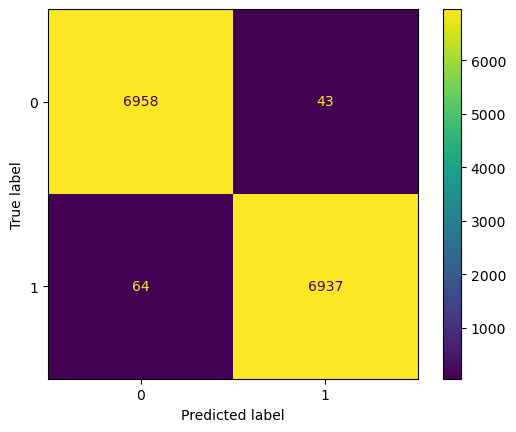

Test Evaluation
Precision: 0.9525
Recall: 0.9537
F1 Score: 0.9531


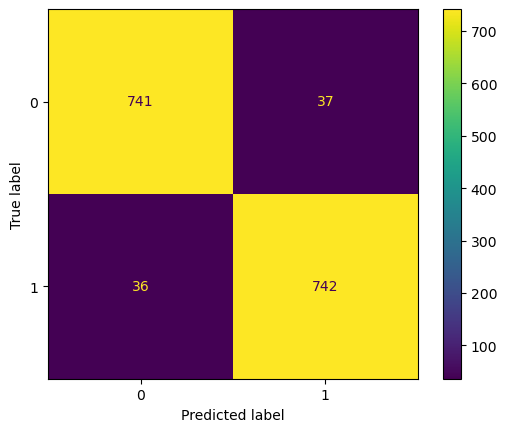

Cross-Validation Accuracy: 0.9397
Best hyperparameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}


In [ ]:
# Define the base model
rf = RandomForestClassifier(random_state=42)
#### need to change the parameters for the RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2', None],
    'max_samples': [0.8, 0.9, 1.0]
}
# Set up GridSearch
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                  # 5-fold cross-validation
    scoring='f1',     # You can change to 'f1' if more suitable
    n_jobs=8,
    verbose=1
)

# Run Grid Search
grid_search.fit(X_train_scaled, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Train and evaluate
y_train_hat = best_rf.predict(X_train_scaled)
y_hat = best_rf.predict(X_test_scaled)

print("Train Evaluation")
evaluate_model(y_train, y_train_hat)
print("Test Evaluation")
evaluate_model(y_test, y_hat)

# Cross-validation score
cv_score = cross_val_score(best_rf, X_train_scaled, y_train, cv=5).mean()
print(f"Cross-Validation Accuracy: {cv_score:.4f}")

# Print best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Train Evaluation
Precision: 0.9816
Recall: 0.9730
F1 Score: 0.9773


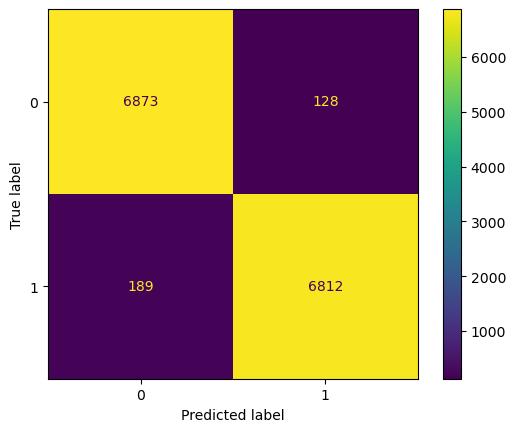

Test Evaluation
Precision: 0.9627
Recall: 0.9627
F1 Score: 0.9627


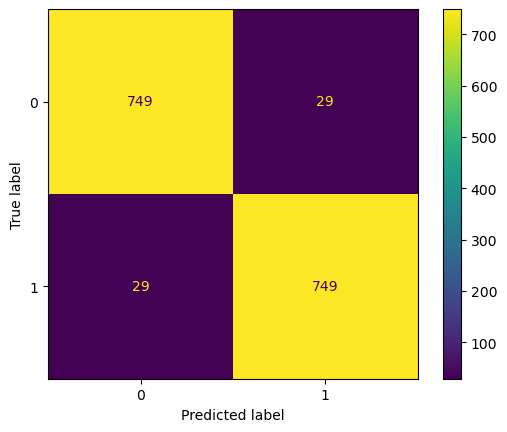

Cross-Validation F1 Score: 0.9575
Best hyperparameters: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}


In [69]:
# Base model
svm = SVC(random_state=42)

# Define hyperparameter grid
param_grid = {
    'C': [1,10],           # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types
    'gamma': ['scale', 'auto'],        # Kernel coefficient
    'degree': [3, 4]                # Degree for 'poly' kernel
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    scoring='f1',   # <<--- Focus on F1 score
    n_jobs=10,
    verbose=1
)

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

# Best model
best_svm = grid_search.best_estimator_

# Train and predict
y_train_hat = best_svm.predict(X_train_scaled)
y_hat = best_svm.predict(X_test_scaled)

print("Train Evaluation")
evaluate_model(y_train, y_train_hat)
print("Test Evaluation")
evaluate_model(y_test, y_hat)

# Cross-validation score (F1)
cv_score = cross_val_score(best_svm, X_train_scaled, y_train, cv=5, scoring='f1').mean()
print(f"Cross-Validation F1 Score: {cv_score:.4f}")

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


d:\anaconda\envs\tf_env\lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Evaluation
Precision: 0.9784
Recall: 0.9700
F1 Score: 0.9742


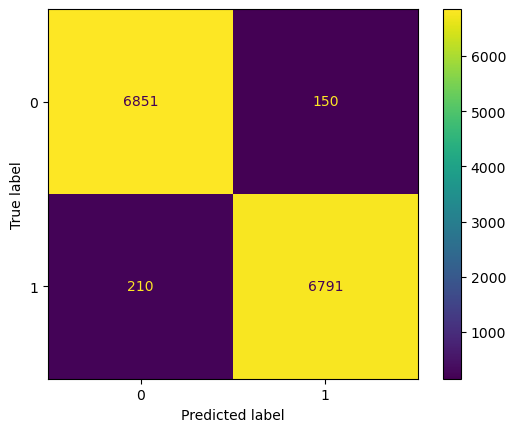

Test Evaluation
Precision: 0.9561
Recall: 0.9524
F1 Score: 0.9543


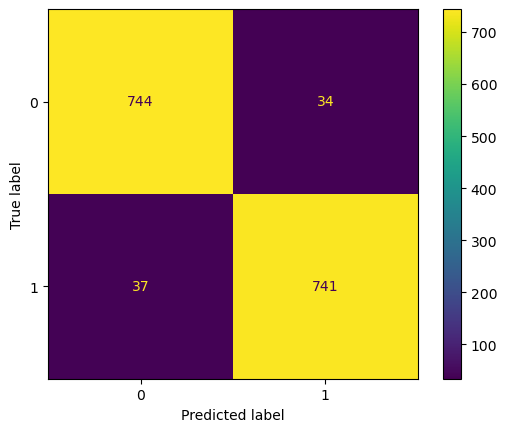

d:\anaconda\envs\tf_env\lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\anaconda\envs\tf_env\lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\anaconda\envs\tf_env\lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\anaconda\envs\tf_env\lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

Cross-Validation F1 Score: 0.9479
Best hyperparameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.6}


In [73]:

# Base model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 150],           # Reduced number of trees for faster training
    'max_depth': [2, 3,5],                # Lower max depth to prevent overfitting
    'learning_rate': [0.01, 0.05],        # Lower learning rate for finer adjustments
    'subsample': [0.6, 0.7],              # Row sampling for stronger regularization
    'colsample_bytree': [0.6, 0.7],       # Feature sampling for stronger regularization
    'gamma': [0.1, 0.2],                  # Added gamma to further regularize the model
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',  # <<--- Focus on F1 score
    cv=5,
    n_jobs=8,
    verbose=1
)

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

# Best model
best_xgb = grid_search.best_estimator_

# Train and predict
y_train_hat = best_xgb.predict(X_train_scaled)
y_hat = best_xgb.predict(X_test_scaled)

print("Train Evaluation")
evaluate_model(y_train, y_train_hat)
print("Test Evaluation")
evaluate_model(y_test, y_hat)

# Cross-validation score (F1)
cv_score = cross_val_score(best_xgb, X_train_scaled, y_train, cv=5, scoring='f1').mean()
print(f"Cross-Validation F1 Score: {cv_score:.4f}")

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Train Evaluation
Precision: 0.9429
Recall: 0.9384
F1 Score: 0.9407


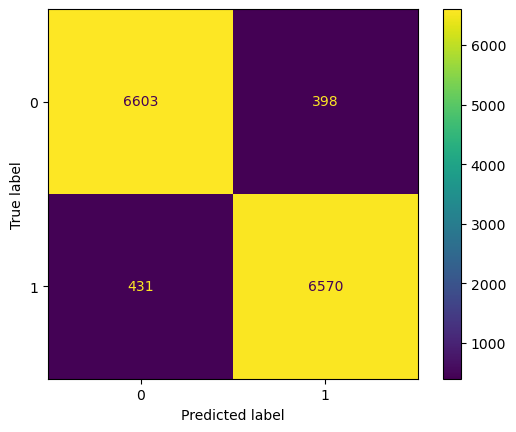

Test Evaluation
Precision: 0.9446
Recall: 0.9422
F1 Score: 0.9434


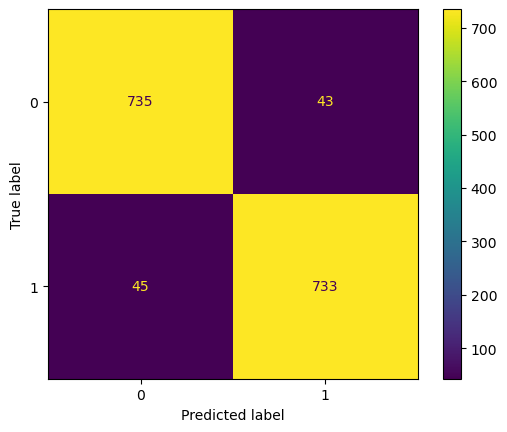

Cross-Validation F1 Score: 0.9346
Best hyperparameters: {'learning_rate': 1.0, 'n_estimators': 200}


In [71]:

adaboost = AdaBoostClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],    # Number of weak learners
    'learning_rate': [0.01, 0.1, 1.0]  # Learning rate
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=adaboost,
    param_grid=param_grid,
    scoring='f1',   # <<--- Focus on F1 score
    cv=5,
    n_jobs=8,
    verbose=1
)

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

# Best model
best_adaboost = grid_search.best_estimator_

# Train and predict
y_train_hat = best_adaboost.predict(X_train_scaled)
y_hat = best_adaboost.predict(X_test_scaled)

print("Train Evaluation")
evaluate_model(y_train, y_train_hat)
print("Test Evaluation")
evaluate_model(y_test, y_hat)

# Cross-validation F1 score
cv_score = cross_val_score(best_adaboost, X_train_scaled, y_train, cv=5, scoring='f1').mean()
print(f"Cross-Validation F1 Score: {cv_score:.4f}")

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Train Evaluation
Precision: 0.9618
Recall: 0.9399
F1 Score: 0.9507


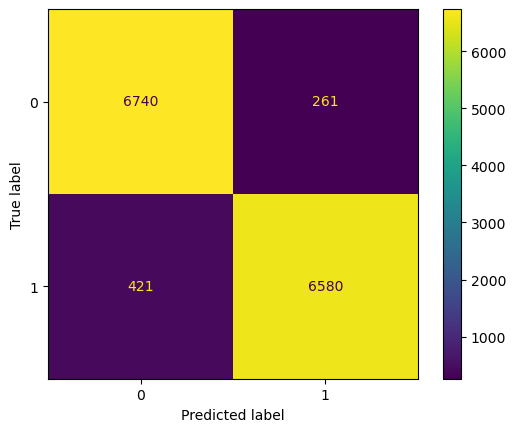

Test Evaluation
Precision: 0.9619
Recall: 0.9422
F1 Score: 0.9519


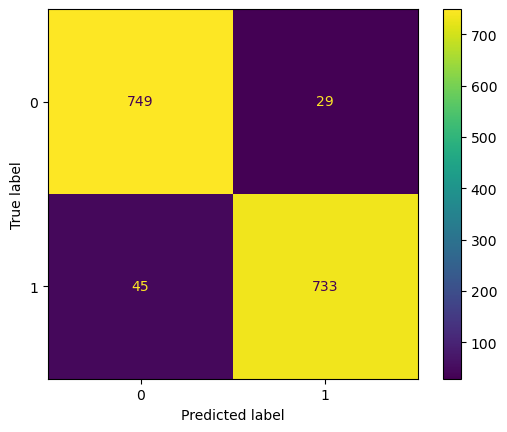

Cross-Validation F1 Score: 0.9377
Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}


In [72]:
from sklearn.neighbors import KNeighborsClassifier

# Base model
knn = KNeighborsClassifier()

# Define hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],      # Number of neighbors
    'weights': ['uniform', 'distance'],   # Weight function
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='f1',  # <<--- Focus on F1 score
    cv=5,
    n_jobs=8,
    verbose=1
)

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

# Best model
best_knn = grid_search.best_estimator_

# Train and predict
y_train_hat = best_knn.predict(X_train_scaled)
y_hat = best_knn.predict(X_test_scaled)

print("Train Evaluation")
evaluate_model(y_train, y_train_hat)
print("Test Evaluation")
evaluate_model(y_test, y_hat)

# Cross-validation F1 score
cv_score = cross_val_score(best_knn, X_train_scaled, y_train, cv=5, scoring='f1').mean()
print(f"Cross-Validation F1 Score: {cv_score:.4f}")

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
